In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Step 1 & 2. 데이터 로딩 및 전처리

In [2]:
filename = os.getenv("HOME") + '/aiffel/transformer_chatbot/data/ChatbotData .csv'

In [3]:
df = pd.read_csv(filename)
print(df.shape)
df.head()

(11823, 3)


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
df = df.drop(columns='label')
df.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


11823 개의 데이터가 있음. 필요없는 label column drop

In [5]:
df.isnull().sum()

Q    0
A    0
dtype: int64

데이터에 빈값 없는 것 확인

In [6]:
df.duplicated(['Q']).sum()

161

In [7]:
df.duplicated(['A']).sum()

4044

In [8]:
df.duplicated(['Q', 'A']).sum()

73

In [9]:
df.duplicated().sum()

73

Q column에 대하여 drop_duplicates 실행

In [10]:
df = df.drop_duplicates(subset=['Q'])

print(df.duplicated(['Q']).sum(), df.shape)

0 (11662, 2)


In [11]:
df['Q'].apply(lambda t: len(t.split())).describe()

count    11662.000000
mean         3.593466
std          1.619695
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         15.000000
Name: Q, dtype: float64

In [12]:
df['A'].apply(lambda t: len(t.split())).describe()

count    11662.000000
mean         3.698251
std          1.858818
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         21.000000
Name: A, dtype: float64

In [13]:
print(df.loc[23, ['Q', 'A']])

print(df.loc[1557, ['Q', 'A']])

print(df.loc[100, ['Q', 'A']])

print(df.loc[11661, ['Q', 'A']])

Q                 가족 여행 가기로 했어
A    온 가족이 모두 마음에 드는 곳으로 가보세요.
Name: 23, dtype: object
Q              맛집 다녀왔어
A    맛있게 드시고 오셨길 바랍니다.
Name: 1557, dtype: object
Q                거지됐어
A    밥 사줄 친구를 찾아 보세요~
Name: 100, dtype: object
Q              첫사랑도 내가 보고 싶을까?
A    추억으로 남았다면 보고 싶고 궁금할거 같아요.
Name: 11661, dtype: object


In [14]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ㄱ-ㅎ, ㅏ-ㅣ, 가-힣, ".", "?", "!", ",", 숫자)를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,\d]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [15]:
df['Q_clean'] = df['Q'].apply(lambda s: preprocess_sentence(s))
df['A_clean'] = df['A'].apply(lambda s: preprocess_sentence(s))

In [16]:
df.head()

,Q,A,Q_clean,A_clean
0,12시 땡!,하루가 또 가네요.,12시 땡 !,하루가 또 가네요 .
1,1지망 학교 떨어졌어,위로해 드립니다.,1지망 학교 떨어졌어,위로해 드립니다 .
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .
4,PPL 심하네,눈살이 찌푸려지죠.,ppl 심하네,눈살이 찌푸려지죠 .


## Step 3. SubwordTextEncoder 사용하기

### 질문과 답변 데이터셋에 대해서 Vocabulary 생성

In [17]:
pd.concat([df['Q_clean'], df['A_clean']])

0                          12시 땡 !
1                      1지망 학교 떨어졌어
2                     3박4일 놀러가고 싶다
3                  3박4일 정도 놀러가고 싶다
4                          ppl 심하네
                   ...            
11817               진심으로 다가가 보세요 .
11818          티가 나니까 눈치가 보이는 거죠 !
11820                      설렜겠어요 .
11821    잘 헤어질 수 있는 사이 여부인 거 같아요 .
11822          도피성 결혼은 하지 않길 바라요 .
Length: 23324, dtype: object

In [18]:
from collections import Counter
results = Counter()
pd.concat([df['Q_clean'], df['A_clean']]).str.split().apply(results.update)
print(len(results))

20651


단어가 20651개밖에 없으니까 vocab_size를 늘려서 모든 단어를 담아봄.

In [19]:
import tensorflow_datasets as tfds


tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    pd.concat([df['Q_clean'], df['A_clean']]), target_vocab_size=2**13
)

시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.

In [20]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2
print(START_TOKEN, END_TOKEN, VOCAB_SIZE)

[8106] [8107] 8108


In [21]:
questions = df['Q_clean']
answers = df['A_clean']

In [22]:
print("정수 인코딩 후의 21번째 질문 샘플: {}".format(tokenizer.encode(questions[21])))
print("정수 인코딩 후의 21번째 답변 샘플: {}".format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5737, 634, 2480, 4135]
정수 인코딩 후의 21번째 답변 샘플: [2331, 7460, 7, 6223, 96, 1]


In [23]:
df['Q_clean'].apply(lambda t: len(t.split())).describe()

count    11662.000000
mean         3.948551
std          1.847341
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         16.000000
Name: Q_clean, dtype: float64

In [24]:
df['A_clean'].apply(lambda t: len(t.split())).describe()

count    11662.00000
mean         4.72106
std          1.92572
min          1.00000
25%          3.00000
50%          4.00000
75%          6.00000
max         24.00000
Name: A_clean, dtype: float64

모든 문장을 학습해보고자 MAX_LENGTH 를 최대치로 줌

In [25]:
MAX_LENGTH = 16

In [26]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for sentence1, sentence2 in zip(inputs, outputs):
        # 최대 길이 MAX_LENGTH 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) > MAX_LENGTH and len(sentence2) > MAX_LENGTH:
            continue
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    # 최대 길이 MAX_LENGTH + 2으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH + 2, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH + 2, padding="post"
    )

    return tokenized_inputs, tokenized_outputs


In [27]:
questions, answers = tokenize_and_filter(questions, answers)

In [28]:
print("단어장의 크기 :", (VOCAB_SIZE))
print("필터링 후의 질문 샘플 개수: {}".format(len(questions)))
print("필터링 후의 답변 샘플 개수: {}".format(len(answers)))

단어장의 크기 : 8108
필터링 후의 질문 샘플 개수: 10101
필터링 후의 답변 샘플 개수: 10101


In [29]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": questions, "dec_inputs": answers[:, :-1]},
        {"outputs": answers[:, 1:]},
    )
)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기

###  포지셔널 인코딩 레이어

In [30]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles  # position * d_model

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[
                :, tf.newaxis
            ],  # position * 1  matrix
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],  # 1 * d_model matrix
            d_model=d_model,
        )

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])  # postion * d_model/2
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])  # postion * d_model/2

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)  # 2 * position * d_model/2
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])  # position * d_model/2 * 2
        pos_encoding = tf.reshape(
            pos_encoding, [position, d_model]
        )  # position * d_model

        pos_encoding = pos_encoding[tf.newaxis, ...]  # 1* position * d_model
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]


(1, 50, 512)


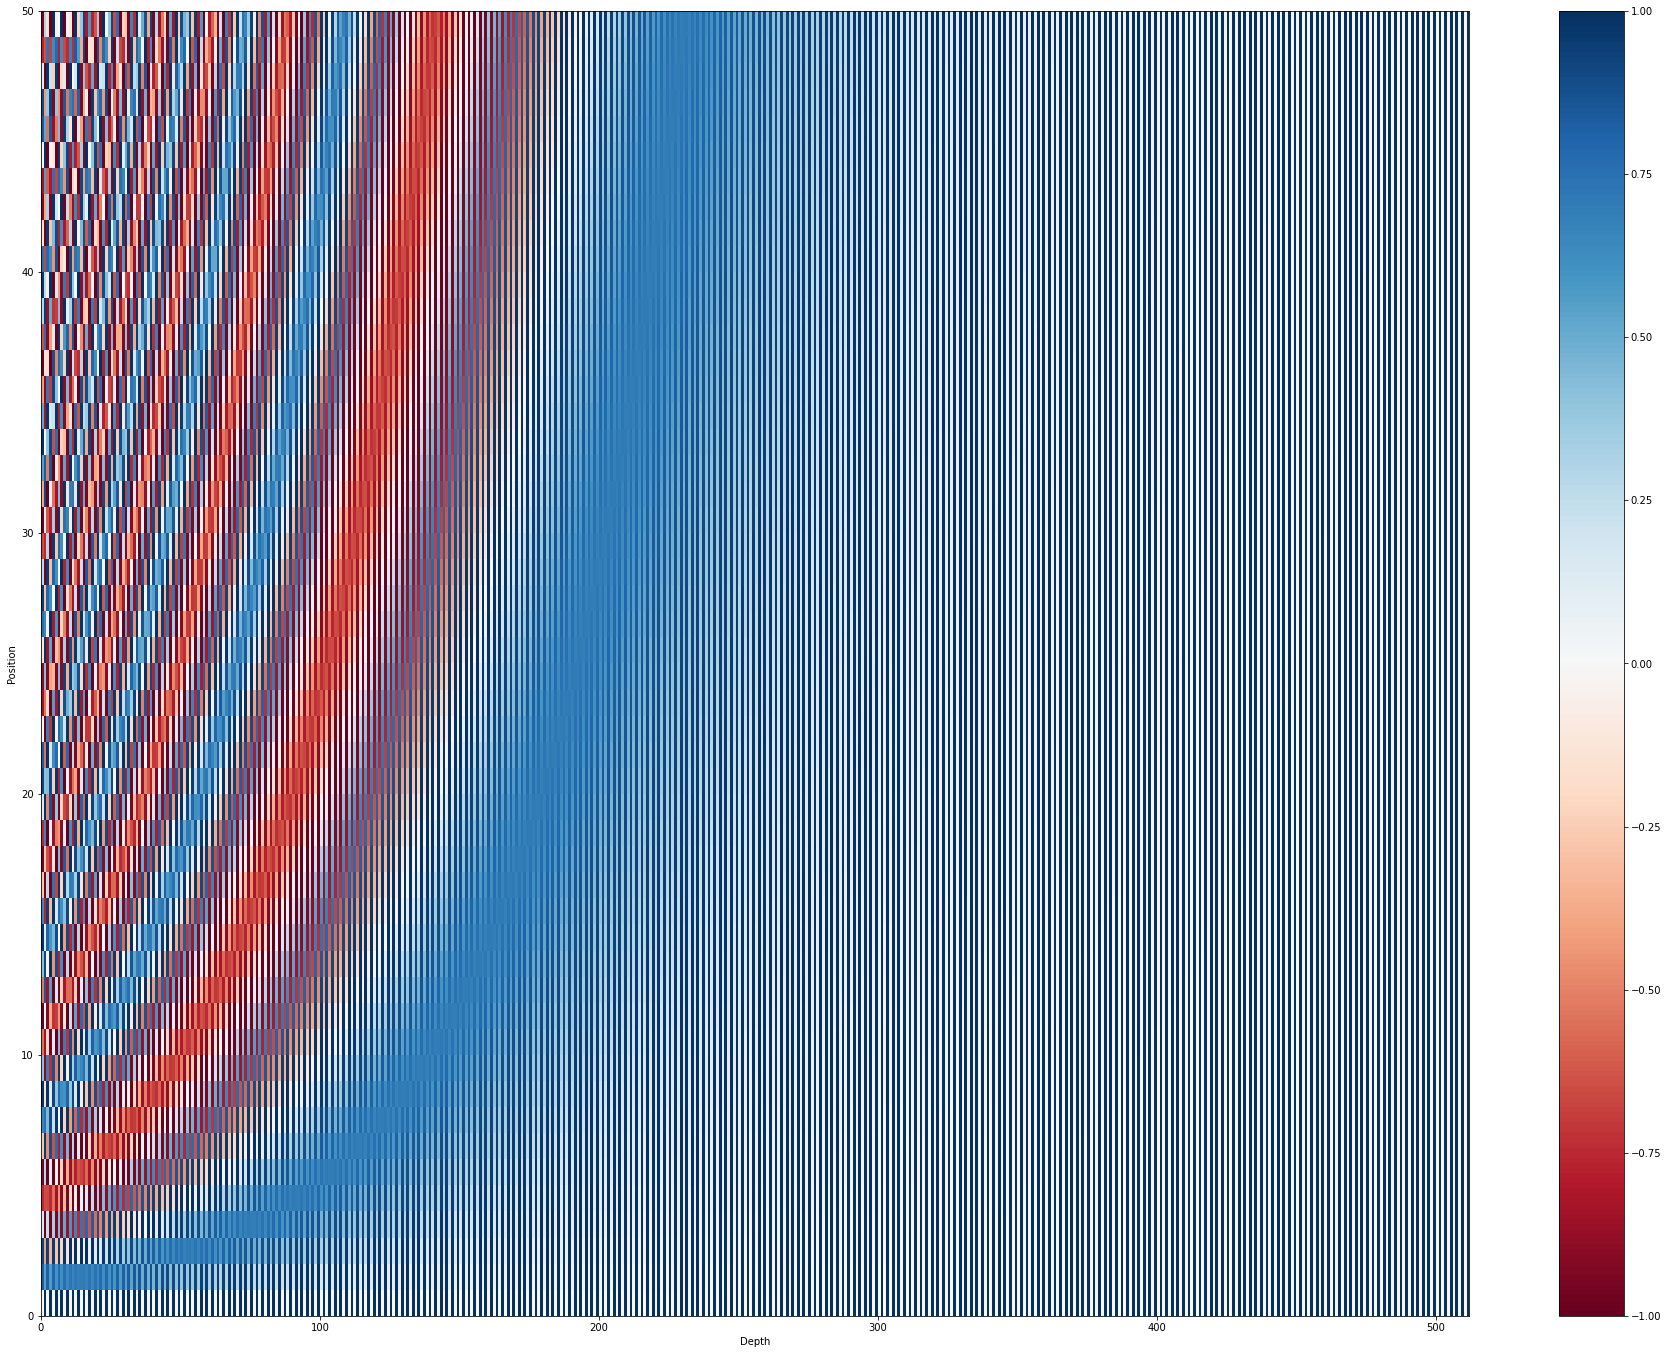

In [31]:
sample_pos_encoding = PositionalEncoding(50, 512)
plt.figure(figsize=(32, 24))
print(sample_pos_encoding.pos_encoding.numpy().shape)
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

### 멀티헤드 어텐션 레이어 구축

In [32]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)  # str_len * str_len

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)  # depth
    logits = matmul_qk / tf.math.sqrt(depth)  # str_len * str_len

    # 패딩에 마스크 추가
    if mask is not None:
        logits += mask * -1e9

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)  # str_len * str_len

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)  # str_len * depth
    return output

In [33]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        # inputs = batch_size * str_len * d_model
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)
        )  # batch_size * str_len * num_heads * depth
        return tf.transpose(
            inputs, perm=[0, 2, 1, 3]
        )  # batch_size * num_heads * str_len * depth

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)  # batch_size * str_len * d_model
        key = self.key_dense(key)  # batch_size * str_len * d_model
        value = self.value_dense(value)  # batch_size * str_len * d_model

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(
            query, batch_size
        )  # batch_size * num_heads * str_len * depth
        key = self.split_heads(
            key, batch_size
        )  # batch_size * num_heads * str_len * depth
        value = self.split_heads(
            value, batch_size
        )  # batch_size * num_heads * str_len * depth

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(
            query, key, value, mask
        )  # batch_size * num_heads * str_len * depth

        scaled_attention = tf.transpose(
            scaled_attention, perm=[0, 2, 1, 3]
        )  # batch_size * str_len * num_heads * depth

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(
            scaled_attention, (batch_size, -1, self.d_model)
        )  # batch_size * str_len * d_model

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)  # batch_size * str_len * d_model

        return outputs

### 마스크 처리

In [34]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [35]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### 인코더 모델 구성

In [36]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [37]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더 모델 구성

In [38]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(
        attention2 + attention1
    )

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

In [39]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )


### 트랜스포머 모델 구성

In [40]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


In [41]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2  # 인코더와 디코더의 층의 개수
D_MODEL = 256  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512  # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1  # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3129856     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 손실 함수 구성

In [42]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH + 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)


### 학습시 러닝레이트 조절

In [43]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [44]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)


def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH + 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [45]:
EPOCHS = 40
history = model.fit(dataset, epochs=EPOCHS, verbose=2)

Epoch 1/40
158/158 - 12s - loss: 3.1800 - accuracy: 0.0640
Epoch 2/40
158/158 - 5s - loss: 2.6491 - accuracy: 0.1128
Epoch 3/40
158/158 - 6s - loss: 2.2365 - accuracy: 0.1143
Epoch 4/40
158/158 - 6s - loss: 2.0408 - accuracy: 0.1190
Epoch 5/40
158/158 - 6s - loss: 1.9189 - accuracy: 0.1258
Epoch 6/40
158/158 - 6s - loss: 1.8033 - accuracy: 0.1329
Epoch 7/40
158/158 - 6s - loss: 1.6819 - accuracy: 0.1432
Epoch 8/40
158/158 - 6s - loss: 1.5463 - accuracy: 0.1574
Epoch 9/40
158/158 - 6s - loss: 1.3958 - accuracy: 0.1746
Epoch 10/40
158/158 - 6s - loss: 1.2355 - accuracy: 0.1937
Epoch 11/40
158/158 - 6s - loss: 1.0637 - accuracy: 0.2140
Epoch 12/40
158/158 - 6s - loss: 0.8907 - accuracy: 0.2369
Epoch 13/40
158/158 - 6s - loss: 0.7241 - accuracy: 0.2592
Epoch 14/40
158/158 - 6s - loss: 0.5685 - accuracy: 0.2818
Epoch 15/40
158/158 - 6s - loss: 0.4325 - accuracy: 0.3039
Epoch 16/40
158/158 - 6s - loss: 0.3161 - accuracy: 0.3234
Epoch 17/40
158/158 - 6s - loss: 0.2253 - accuracy: 0.3400
Epoch

## Step 5. 모델 평가하기

In [46]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [47]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )

    print("입력 : {}".format(sentence))
    print("출력 : {}".format(predicted_sentence))

    return predicted_sentence

#### 안에 데이터가 있는지 잘 나온 부분

In [48]:
question_list = ['안녕 오랜만이야', '잘 지냈어?', '뭐 먹을까?', '메뉴 추천해줘', '어제 뭐 먹었어?', '나랑 놀자', '어디 가고 싶어?', '여행 갈래?']

for question in question_list:
    sentence_generation(question)
    print('')

입력 : 안녕 오랜만이야
출력 : 안녕하세요 .

입력 : 잘 지냈어?
출력 : 안부를 물어주시다니 감사합니다 .

입력 : 뭐 먹을까?
출력 : 좀 먹어도 괜찮아요 .

입력 : 메뉴 추천해줘
출력 : 좀 먹어도 괜찮아요 .

입력 : 어제 뭐 먹었어?
출력 : 저는 배터리가 밥이예요 .

입력 : 나랑 놀자
출력 : 지금 그러고 있어요 .

입력 : 어디 가고 싶어?
출력 : 즐거운 시간 보내시길 바랍니다 .

입력 : 여행 갈래?
출력 : 저는 좋아요 .



In [49]:
sentence_generation("짝남 때문에 너무 우울하고 혼란스러워")

입력 : 짝남 때문에 너무 우울하고 혼란스러워
출력 : 충분히 힘들거라 생각해요 .


'충분히 힘들거라 생각해요 .'

#### 학습되지 않아서 그런지 다소 미흡한 결과

In [50]:
sentence_generation('만나서 기뻐')

입력 : 만나서 기뻐
출력 : 가끔씩 스트레칭을 해주세요 .


'가끔씩 스트레칭을 해주세요 .'

In [51]:
sentence_generation('너를 만나서 기뻐')

입력 : 너를 만나서 기뻐
출력 : 지금 당장 자들였을 거예요 .


'지금 당장 자들였을 거예요 .'

In [52]:
sentence_generation('당신을 만나서 기뻐')

입력 : 당신을 만나서 기뻐
출력 : 지금 옆에서 기뻐해주는 사람을 살펴보세요 .


'지금 옆에서 기뻐해주는 사람을 살펴보세요 .'

In [53]:
sentence_generation('널 만나서 기뻐')

입력 : 널 만나서 기뻐
출력 : 지금 그러고 있어요 .


'지금 그러고 있어요 .'

In [54]:
sentence_generation("아이펠이 뭐야?")

입력 : 아이펠이 뭐야?
출력 : 잠재력은 무궁무진해요 .


'잠재력은 무궁무진해요 .'

In [55]:
sentence_generation("크리스마스에는 뭐해?")

입력 : 크리스마스에는 뭐해?
출력 : 크리스마스에는 케빈과 함께 .


'크리스마스에는 케빈과 함께 .'

# 회고



## 결과 비교 

**epoch = 40일 때, max_lenght = 24, vocab_size = 2^15**  

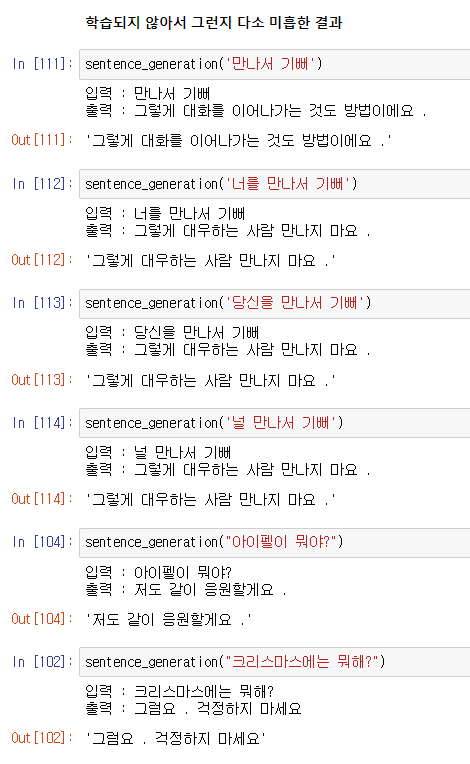  




**epoch = 40일 때, max_lenght = 16, vocab_size = 2^13**  

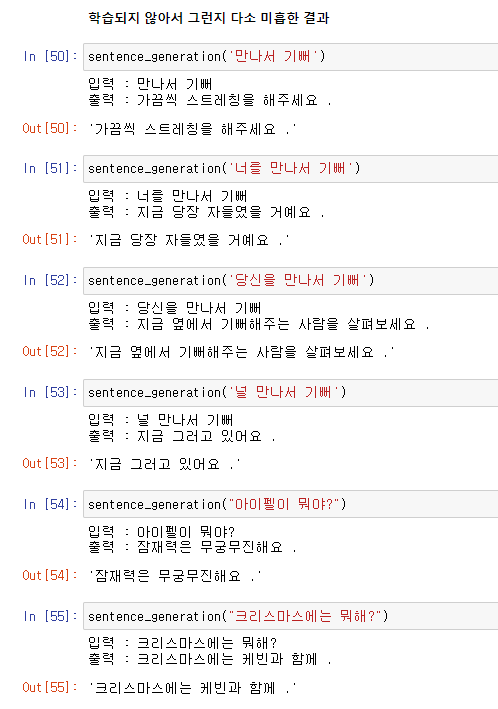



## 느낀점 
* Transformer를 이용해서 질문에 대한 모델의 답변을 보는 과정이 즐거웠다. 
* 개념적으로 더 탄탄한 시간을 가져야겠다. 
* vocab size와 max_length 사이즈를 줄이면 모델의 정확도가 더 올라간다는 것을 알게 되었다. 다음에 시간이 되면 더 시도해봐야겠다.